# Deep Learning with PyTorch : Build a Generative Adversarial Network 

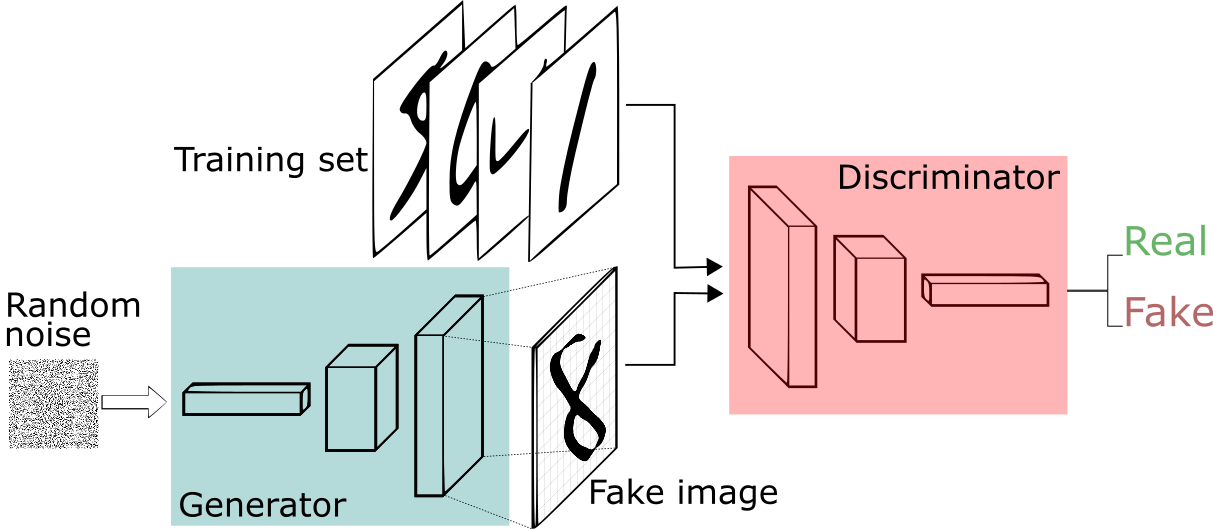

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
noise_dim = 64  # used in generator
# optimizes' parameters
lr = 0.0002
beta_1 = 0.5
beta_2 =.099
# training variables
epochs = 20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
      T.RandomRotation((-20, 20)),
      T.ToTensor()  # shift dim: (h, w, c) --> (c, h, w)
])

In [5]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 108437821.12it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36630085.83it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26639233.77it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16366433.65it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



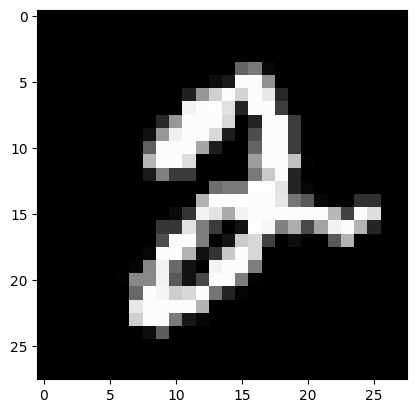

In [6]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')

In [7]:
print('Total images in trainset:', len(trainset))

Total images in trainset: 60000


# Load Dataset Into Batches 

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [10]:
print('Total number of batches in trainloader:', len(trainloader))

Total number of batches in trainloader: 469


In [11]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

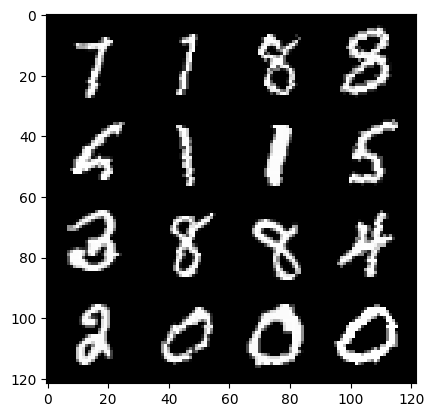

In [13]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network 

In [14]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from torch import nn
from torchsummary import summary

In [16]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [17]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [18]:
class Discriminator(nn.Module):
  def __init__(self) -> None:
    super(Discriminator, self).__init__()
    
    self.block_1 = get_disc_block(1, 16, (3, 3), 2)
    self.block_2 = get_disc_block(16, 32, (5, 5), 2)
    self.block_3 = get_disc_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1) # no need sigmoid since use binary_crossentropy with logit loss (take raw output)
    
  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [19]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [20]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [21]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [22]:
class Generator(nn.Module):
  def __init__(self, noise_dim) -> None:
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3, 3), 2, False)
    self.block_2 = get_gen_block(256, 128, (4, 4), 1, False)
    self.block_3 = get_gen_block(128, 64, (3, 3), 2, False)
    self.block_4 = get_gen_block(64, 1, (4, 4), 2, True)
  
  def forward(self, rand_noise_vec):
    # rand_noise_vec.shape = (bs, noise_dim) --> (bs, noise_dim, 1, 1)
    x= rand_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [23]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [24]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [25]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In the real_loss() function, the ground truth tensor is a tensor of ones, because the discriminator is being trained to correctly classify real data as real. Therefore, the loss is calculated by comparing the discriminator's output for real data with the ground truth, which is a tensor of ones.

In the fake_loss() function, the ground truth tensor is a tensor of zeros, because the discriminator is being trained to correctly classify fake data as fake. Therefore, the loss is calculated by comparing the discriminator's output for fake data with the ground truth, which is a tensor of zeros.

In [26]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [27]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))


# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 	 D_loss: 0.6859860970521532 	 G_loss: 0.6938520708063772


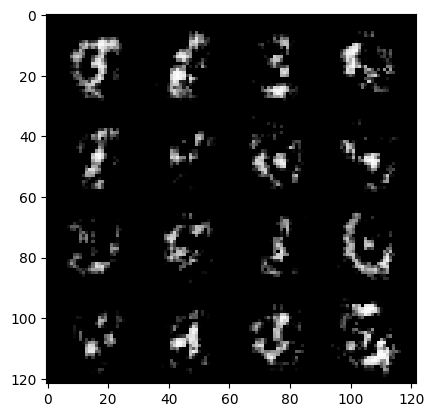

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 	 D_loss: 0.6857681264246959 	 G_loss: 0.7021641492335273


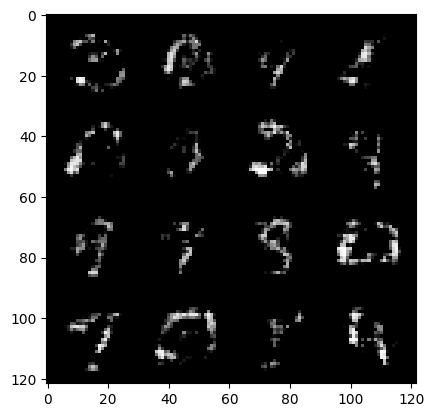

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 	 D_loss: 0.6733357226416501 	 G_loss: 0.722261268955304


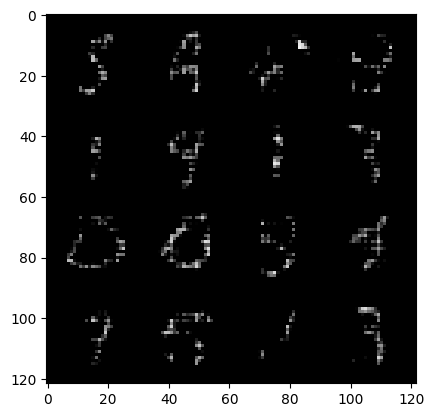

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 	 D_loss: 0.6437133886158339 	 G_loss: 0.75869387744078


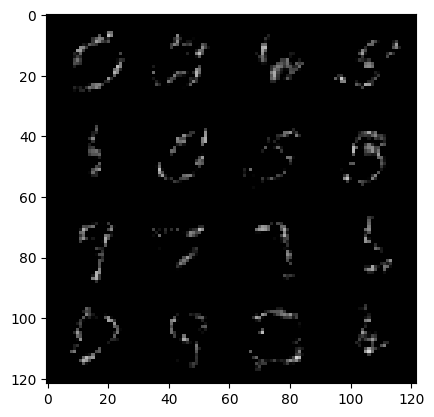

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 	 D_loss: 0.6113324516109312 	 G_loss: 0.8084836611107215


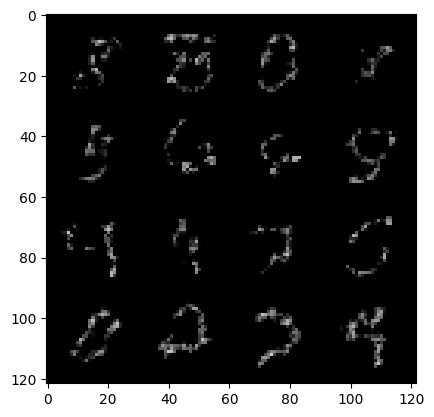

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 	 D_loss: 0.5940703565377925 	 G_loss: 0.8551968144201266


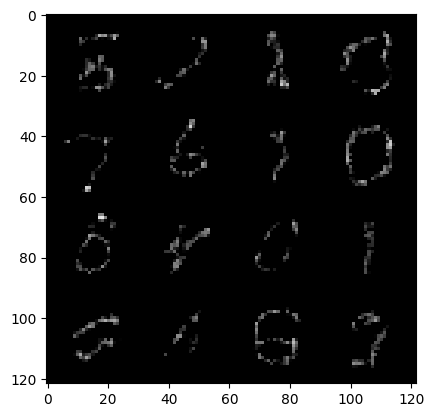

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 	 D_loss: 0.5911035142473574 	 G_loss: 0.8828474327699461


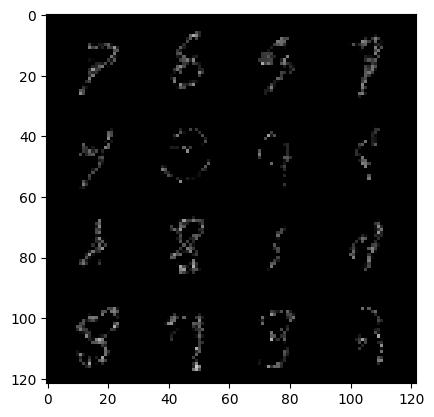

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 	 D_loss: 0.5835329751724373 	 G_loss: 0.9170708383070126


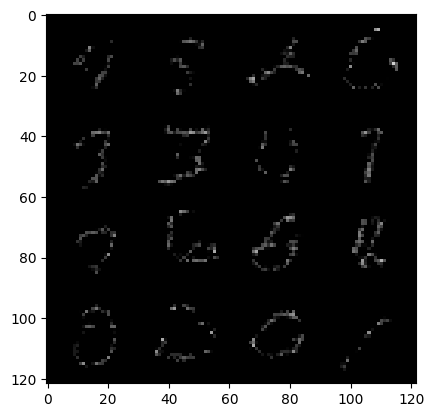

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 	 D_loss: 0.5860059244800478 	 G_loss: 0.9314087662361324


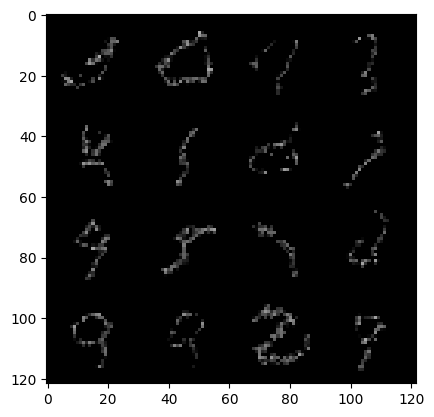

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 	 D_loss: 0.5822690508004699 	 G_loss: 0.9563885880177463


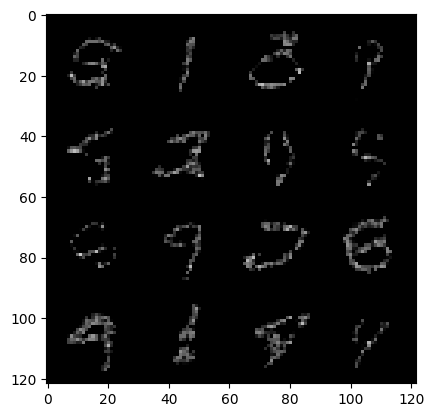

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 	 D_loss: 0.5720584817024182 	 G_loss: 0.9943302402109988


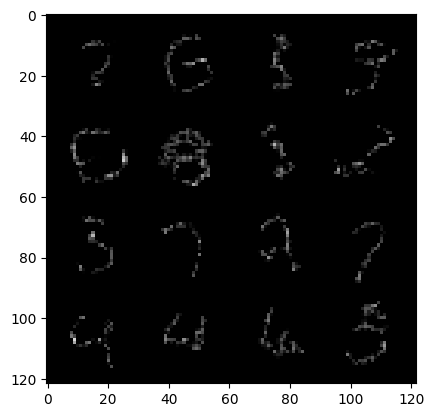

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 	 D_loss: 0.5630272643398374 	 G_loss: 1.0376498536514576


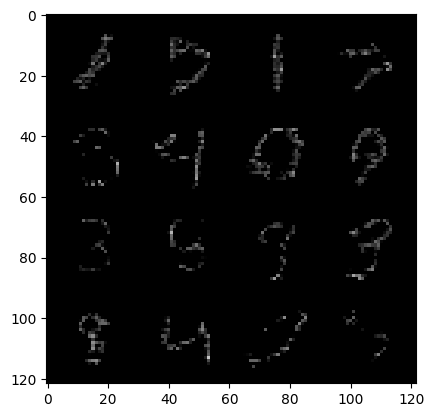

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 	 D_loss: 0.5571188380850404 	 G_loss: 1.0606923522725542


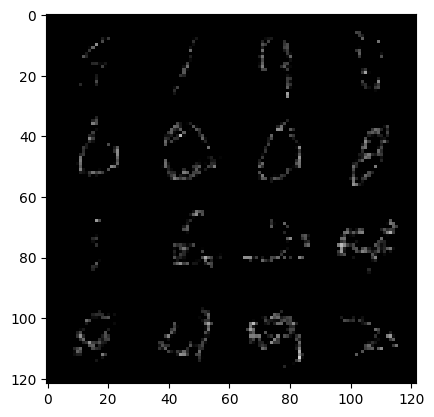

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 	 D_loss: 0.5493756356651086 	 G_loss: 1.0895315291784973


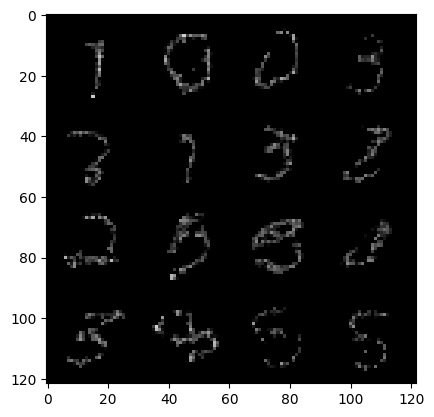

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 	 D_loss: 0.5428669190228875 	 G_loss: 1.1220115167754037


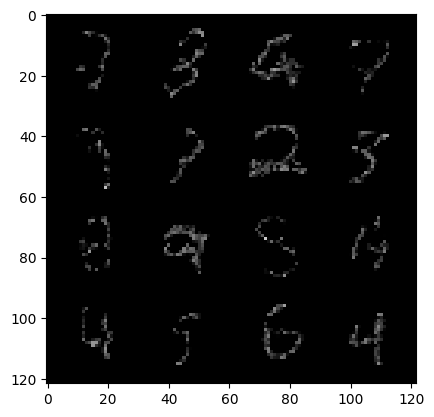

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 	 D_loss: 0.5448053270133574 	 G_loss: 1.1395107107375986


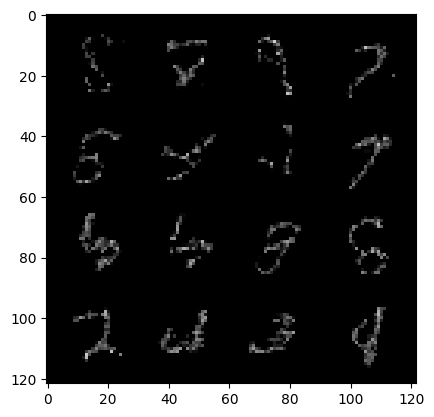

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 	 D_loss: 0.530902826074344 	 G_loss: 1.1578371151169735


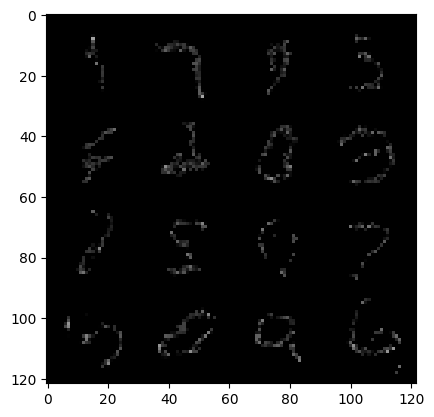

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 	 D_loss: 0.5370564628511604 	 G_loss: 1.1673826765912427


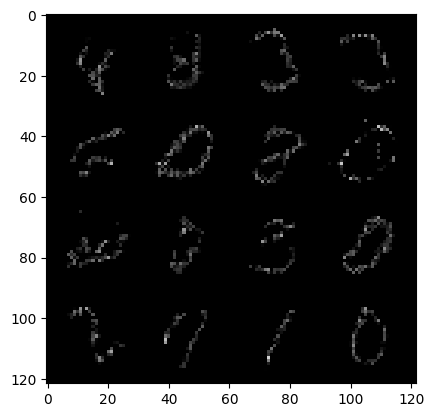

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 	 D_loss: 0.5368782145255155 	 G_loss: 1.1755668881859607


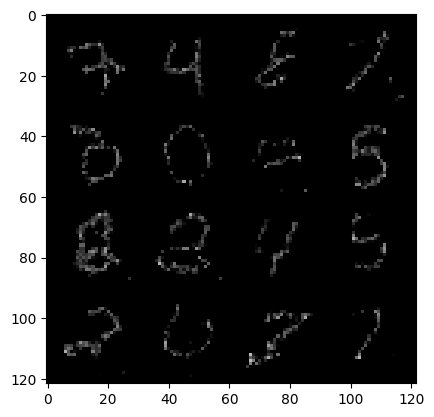

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 	 D_loss: 0.527089003751527 	 G_loss: 1.1926406564743026


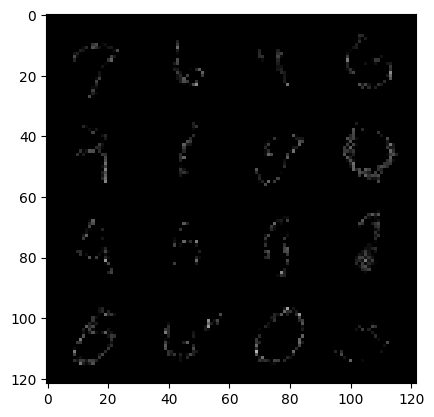

In [28]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    # find loss + update weights for D
    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2.0
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss + update weights for G
    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)
    
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)  # want to generate as real as possible
    total_g_loss += G_loss.item()
    
    G_loss.backward()
    G_opt.step()
  
  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print('Epoch: {} \t D_loss: {} \t G_loss: {}'.format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img)

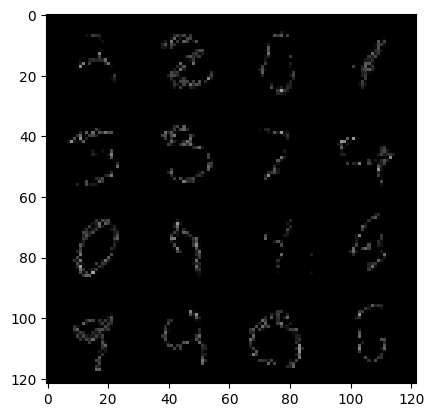

In [29]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya